# Evaluate models, generate metrics and plots

The notebook also generates predictions from different models. If the predictions are already generated, just run the cells below "group results together" and its dependencies including the imports below.

**Warning:** The notebook requires GPU and 16GB RAM to run. We recommend running the cell below with imports and running all the cells under "Group results together" heading cell to directly use the already generated predictions. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, Binarizer

from joblib import load, dump
import joblib
import pickle

import gc
import sys

%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)

# Results for aggregated models

## Load data

In [3]:
filepath_6m = 'data/6 month/'
data_6m = pd.read_feather(filepath_6m + 'flat_6m.feather')
filepath_12m = 'data/12 month/'
data_12m = pd.read_feather(filepath_12m + 'flat_12m.feather')

# drop age outliers
data_6m = data_6m.loc[data_6m['age']<100,:]
data_12m = data_12m.loc[data_12m['age']<100,:]

print('6m : ', data_6m.shape, ' 12m : ', data_12m.shape)

6m :  (89994, 1506)  12m :  (89282, 1510)


In [4]:
with open(filepath_6m + '6m_test_ids.pkl', 'rb') as f:
    test_ids_6 = pickle.load(f)

train_6m = data_6m[~data_6m['id'].isin(test_ids_6)]
test_6m = data_6m[data_6m['id'].isin(test_ids_6)]
print('6m train/test : ', train_6m.shape, test_6m.shape)

with open(filepath_12m + '12m_test_ids.pkl', 'rb') as f:
    test_ids_12 = pickle.load(f)
 
train_12m = data_12m[~data_12m['id'].isin(test_ids_12)]
test_12m = data_12m[data_12m['id'].isin(test_ids_12)]
print('12m train/test : ', train_12m.shape, test_12m.shape)

6m train/test :  (71995, 1506) (17999, 1506)
12m train/test :  (71425, 1510) (17857, 1510)


In [5]:
del data_6m
del data_12m

gc.collect()

40

## Preprocess 

In [6]:
from preprocessing import Preprocessor

preproc = Preprocessor()

X_train_6, Y_train_6 = preproc.fit_transform(train_6m)
X_test_6, Y_test_6 = preproc.transform(test_6m)
print(X_train_6.shape, X_test_6.shape)

preproc = Preprocessor()

X_train_12, Y_train_12 = preproc.fit_transform(train_12m)
X_test_12, Y_test_12 = preproc.transform(test_12m)
print(X_train_12.shape, X_test_12.shape)

(71779, 1441) (17954, 1441)
(71236, 1446) (17803, 1446)


In [7]:
assert X_train_6.shape[1] == X_test_6.shape[1]
assert X_train_12.shape[1] == X_test_12.shape[1]

In [8]:
ct6 = ColumnTransformer(
    [("age_norm", MaxAbsScaler(), ['age']),
    ('sex_pass', 'passthrough', ['sex'])],
    remainder=Binarizer())

ct12 = ColumnTransformer(
    [("age_norm", MaxAbsScaler(), ['age']),
    ('sex_pass', 'passthrough', ['sex'])],
    remainder=Binarizer())

## Map models from files

Load models from the file to a dictionary creating a mapping of dict -> model

In [9]:
! ls models/6m\ agg && ls models/12m\ agg

6m_DecisionTreeClassifier.joblib  6m_LogisticRegression.joblib
6m_LGBMClassifier.joblib	  6m_RandomForestClassifier.joblib
12m_DecisionTreeClassifier.joblib  12m_LogisticRegression.joblib
12m_LGBMClassifier.joblib	   12m_RandomForestClassifier.joblib


In [10]:
models12_path = 'models/12m agg/'
models6_path = 'models/6m agg/'

In [11]:
models_6 = {
    'lightgbm': load(models6_path + '6m_LGBMClassifier.joblib'),
    'decisiontree': load(models6_path + '6m_DecisionTreeClassifier.joblib'),
    'randomforest': load(models6_path + '6m_RandomForestClassifier.joblib'),
    'logistic': load(models6_path + '6m_LogisticRegression.joblib')
}

/run/media/surya/F/codes/research/TMU/CKD/CKD-public/env/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/run/media/surya/F/codes/research/TMU/CKD/CKD-public/env/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
models_12 = {
    'lightgbm': load(models12_path + '12m_LGBMClassifier.joblib'),
    'decisiontree': load(models12_path + '12m_DecisionTreeClassifier.joblib'),
    'randomforest': load(models12_path + '12m_RandomForestClassifier.joblib'),
    'logistic': load(models12_path + '12m_LogisticRegression.joblib')
}

/run/media/surya/F/codes/research/TMU/CKD/CKD-public/env/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Generate results and store it in a dict

```python
{
    y: y_true,
    algoname: {
        pred: [],
        pred_proba: []
    }
}
```

In [13]:
ct6.fit(X_train_6)
ct12.fit(X_train_12)

ColumnTransformer(n_jobs=None, remainder=Binarizer(copy=True, threshold=0.0),
                  sparse_threshold=0.3, transformer_weights=None,
                  transformers=[('age_norm', MaxAbsScaler(copy=True), ['age']),
                                ('sex_pass', 'passthrough', ['sex'])],
                  verbose=False)

In [14]:
X_train_12.shape, X_train_6.shape

((71236, 1446), (71779, 1441))

In [15]:
preds_6 = {
    'y': Y_test_6
}

algos_with_preproc = ['logistic']

for algoname, model in tqdm(models_6.items()):
    if algoname in algos_with_preproc:
        X_test = ct6.transform(X_test_6)
    else:
        X_test = X_test_6.copy()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    preds_6[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }

 50%|█████     | 2/4 [00:02<00:03,  1.83s/it][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.3s finished
100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


In [16]:
preds_12 = {
    'y': Y_test_12
}

algos_with_preproc = ['logistic']

for algoname, model in tqdm(models_12.items()):
    if algoname in algos_with_preproc:
        X_test = ct12.transform(X_test_12)
    else:
        X_test = X_test_12.copy()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    preds_12[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }

 50%|█████     | 2/4 [00:02<00:03,  1.50s/it][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.2s finished
100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


In [17]:
dump(preds_6, 'predictions_6m.joblib')

['predictions_6m.joblib']

In [18]:
dump(preds_12, 'predictions_12m.joblib')

['predictions_12m.joblib']

# Results for deep learning and semi-temporal model

```python
{
    y: y_true,
    algoname: {
        pred: [],
        pred_proba: []
    }
}
```

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [20]:
tf.random.set_seed(SEED)

In [21]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


## 6 months

### Deep learning models

In [22]:
from data_loader import DataLoader
import pickle

Load the data generator

In [23]:
with open('data/6 month/diag_dict.pkl', 'rb') as f:
  diag = pickle.load(f)
  diag_ids = list(diag.keys())

with open('data/6 month/drug_dict.pkl', 'rb') as f:
  drug = pickle.load(f)
  drug_ids = list(drug.keys())
    
# get list of ids to use
data_dir = "data"

case = pd.read_feather(data_dir + '/case_age_sex.feather')
control = pd.read_feather(data_dir + '/control_age_sex.feather')

# remove age outliers
case = case.loc[case['age'] < 100]
control = control.loc[control['age'] < 100]

case['label'] = 1
control['label'] = 0
data = pd.concat([case, control])
data = data[data['sex'] != 'U']

info_ids = set(case.id).union(set(control.id))
list_ids = sorted(list(set(diag_ids) & set(drug_ids) & set(info_ids)))
data = data.loc[data['id'].isin(list_ids)]

# train test split
train_ids, test_ids = train_test_split(data[['id', 'label']],
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=data['label'],
                                       random_state=SEED)
train_ids, val_ids = train_test_split(train_ids,
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=train_ids['label'],
                                       random_state=SEED)

train_ids = train_ids['id'].tolist()
val_ids = val_ids['id'].tolist()
test_ids = test_ids['id'].tolist()


def preproc(X, X_, y):

    if X.shape[-1] > 965:
        X = np.delete(X, [(965 + 276)], axis=-1)  # id col in drug
    
    return X, X_, y

test_generator = DataLoader(test_ids,
                            data_dir,
                            '/6 month',
                            batch_size=128,
                            include_drug=True,
                            shuffle=False,
                            preprocess_func=preproc)
Y_test = test_generator.get_labels()

deep_preds_6 = {
    'y': Y_test
}

Loading sparse dataset: 100%|██████████| 17998/17998 [00:00<00:00, 623135.14it/s]


In [24]:
# CNN model
cnn6m = load_model('models/6m TS/CNN.hdf5',
                    custom_objects={'f1': f1})
yt_pred = cnn6m.predict_generator(test_generator,
                                  workers=4,
                                  use_multiprocessing=True,
                                  verbose=1)
thresh = 0.5
yt_pred_bin = np.where(yt_pred > thresh, 1, 0)
deep_preds_6['CNN'] = {
        'pred': yt_pred_bin,
        'pred_proba': yt_pred
    }
del cnn6m

# LSTM model
lstm6m = load_model('models/6m TS/BLSTM.hdf5',
                    custom_objects={'f1': f1})
yt_pred = lstm6m.predict_generator(test_generator,
                                  workers=4,
                                  use_multiprocessing=True,
                                  verbose=1)
thresh = 0.5
yt_pred_bin = np.where(yt_pred > thresh, 1, 0)
deep_preds_6['BLSTM'] = {
        'pred': yt_pred_bin,
        'pred_proba': yt_pred
    }
del lstm6m

Instructions for updating:
Please use Model.predict, which supports generators.
140/140 [==============================] - 31s 225ms/step


In [25]:
dump(deep_preds_6, 'deep_predictions_6m.joblib')

['deep_predictions_6m.joblib']

### Semi-temporal methods

Load the saved models

In [26]:
models6_path = 'models/6m ST/'

models_6 = {
    'temp-lightgbm': load(models6_path + '6m_ST_LGBMClassifier.joblib'),
    'temp-decisiontree': load(models6_path + '6m_ST_DecisionTreeClassifier.joblib'),
    'temp-randomforest': load(models6_path + '6m_ST_RandomForestClassifier.joblib'),
    'temp-logistic': load(models6_path + '6m_ST_LogisticRegression.joblib')
}


/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from 

Apply the pre-processing

In [27]:
data = data.set_index('id')
# encode sex
data.loc[data['sex'] == 'M', 'sex'] = 1
data.loc[data['sex'] == 'F', 'sex'] = 0

feat_mask_file = 'data/6 month/6m_top_100_features_mask.joblib'
features_mask = joblib.load(feat_mask_file)

def preproc(X):
    if X.shape[-1] < 965:
        X = np.delete(X, [276], axis=-1)  # id col in drug
        X = X[:,features_mask[965:]]
    else:
        X = X[:,features_mask[:965]]

    return X

def group_sum(arr):
    return np.add.reduceat(arr, indices=np.arange(2, 24, 3), axis=0)

def get_array(arr):
    # get sparse array as input and return preprocessed numpy array
    return group_sum(preproc(arr.toarray())).ravel()
    
def stack_arrays(list_ids):
    """
    Takes a list of ids and returns a numpy array with input values 
    and the target variable in an array
    """
    diag_arr = np.vstack([get_array(diag[id]) for id in list_ids])
    drug_arr = np.vstack([get_array(drug[id]) for id in list_ids])
    age_sex = data.loc[list_ids, ['age', 'sex']].values
    X = np.hstack([diag_arr, drug_arr, age_sex])

    y = data.loc[list_ids, 'label'].values
    return X, y
    
# X_train, y_train = stack_arrays(train_ids)  # we dont need to train
X_test, y_test = stack_arrays(test_ids)

Get predictions for each model

In [28]:
st_preds_6 = {
    'y': y_test
}

for algoname, model in tqdm(models_6.items()):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    st_preds_6[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Cleanup

In [29]:
del X_test, y_test, diag, drug

Save to the predictions file

In [30]:
dump(st_preds_6, 'st_predictions_6m.joblib')

['st_predictions_6m.joblib']

## 12 months

### Deep learning models

In [31]:
with open('data/12 month/diag_dict.pkl', 'rb') as f:
  diag = pickle.load(f)
  diag_ids = list(diag.keys())

with open('data/12 month/drug_dict.pkl', 'rb') as f:
  drug = pickle.load(f)
  drug_ids = list(drug.keys())
    
# get list of ids to use
data_dir = "data/"

case = pd.read_feather(data_dir + '/case_age_sex.feather')
control = pd.read_feather(data_dir + '/control_age_sex.feather')

# remove age outliers
case = case.loc[case['age'] < 100]
control = control.loc[control['age'] < 100]

case['label'] = 1
control['label'] = 0
data = pd.concat([case, control])
data = data[data['sex'] != 'U']

info_ids = set(case.id).union(set(control.id))
list_ids = sorted(list(set(diag_ids) & set(drug_ids) & set(info_ids)))
data = data.loc[data['id'].isin(list_ids)]

# train test split
train_ids, test_ids = train_test_split(data[['id', 'label']],
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=data['label'],
                                       random_state=SEED)
train_ids, val_ids = train_test_split(train_ids,
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=train_ids['label'],
                                       random_state=SEED)

train_ids = train_ids['id'].tolist()
val_ids = val_ids['id'].tolist()
test_ids = test_ids['id'].tolist()


def preproc(X, X_, y):    
    
    if X.shape[-1] > 965:
        X = np.delete(X, [[16, 470, 1063, 1231, 1245]], axis=-1)  # extra & id col in drug
        
    return X, X_, y

test_generator = DataLoader(test_ids,
                            data_dir,
                            '12 month',
                            batch_size=128,
                            include_drug=True,
                            shuffle=False,
                            preprocess_func=preproc)
Y_test = test_generator.get_labels()

deep_preds_12 = {
    'y': Y_test
}

Loading sparse dataset: 100%|██████████| 17856/17856 [00:00<00:00, 617418.59it/s]


In [32]:
# CNN model
cnn12m = load_model('models/12m TS/CNN.hdf5',
                    custom_objects={'f1': f1})
yt_pred = cnn12m.predict_generator(test_generator,
                                  workers=4,
                                  use_multiprocessing=True,
                                  verbose=1)
thresh = 0.5
yt_pred_bin = np.where(yt_pred > thresh, 1, 0)
deep_preds_12['CNN'] = {
        'pred': yt_pred_bin,
        'pred_proba': yt_pred
    }
del cnn12m

# LSTM model
lstm12m = load_model('models/12m TS/BLSTM.hdf5',
                    custom_objects={'f1': f1})
yt_pred = lstm12m.predict_generator(test_generator,
                                  workers=4,
                                  use_multiprocessing=True,
                                  verbose=1)
thresh = 0.5
yt_pred_bin = np.where(yt_pred > thresh, 1, 0)
deep_preds_12['BLSTM'] = {
        'pred': yt_pred_bin,
        'pred_proba': yt_pred
    }
del lstm12m

139/139 [==============================] - 30s 216ms/step


In [33]:
dump(deep_preds_12, 'deep_predictions_12m.joblib')

['deep_predictions_12m.joblib']

### Semi-temporal methods

In [34]:
models12_path = 'models/12m ST/'

models_12 = {
    'temp-lightgbm': load(models12_path + '12m_ST_LGBMClassifier.joblib'),
    'temp-decisiontree': load(models12_path + '12m_ST_DecisionTreeClassifier.joblib'),
    'temp-randomforest': load(models12_path + '12m_ST_RandomForestClassifier.joblib'),
    'temp-logistic': load(models12_path + '12m_ST_LogisticRegression.joblib')
}


/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/surya/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from 

Apply the preprocessing

In [35]:
data = data.set_index('id')
# encode sex
data.loc[data['sex'] == 'M', 'sex'] = 1
data.loc[data['sex'] == 'F', 'sex'] = 0

feat_mask_file = 'data/12 month/12m_top_100_features_mask.joblib'
features_mask = joblib.load(feat_mask_file)

def preproc(X):
    if X.shape[-1] < 965:
        X = np.delete(X, [[1063-965, 1231-965, 1245-965]], axis=-1)  # extra & id col in drug
        X = X[:,features_mask[965:]]
    else:
        X = np.delete(X, [[16, 470]], axis=-1)  # extra & id col in drug
        X = X[:,features_mask[:965]]

    return X

def group_sum(arr):
    return np.add.reduceat(arr, indices=np.arange(2, 24, 3), axis=0)

def get_array(arr):
    # get sparse array as input and return preprocessed numpy array
    return group_sum(preproc(arr.toarray())).ravel()
    
def stack_arrays(list_ids):
    """
    Takes a list of ids and returns a numpy array with input values 
    and the target variable in an array
    """
    diag_arr = np.vstack([get_array(diag[id]) for id in list_ids])
    drug_arr = np.vstack([get_array(drug[id]) for id in list_ids])
    age_sex = data.loc[list_ids, ['age', 'sex']].values
    X = np.hstack([diag_arr, drug_arr, age_sex])

    y = data.loc[list_ids, 'label'].values
    return X, y
    
    
X_test, y_test = stack_arrays(test_ids)

Get predictions for each model

In [36]:
st_preds_12 = {
    'y': y_test
}

for algoname, model in tqdm(models_12.items()):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    st_preds_12[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }

 50%|█████     | 2/4 [00:02<00:01,  1.04it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.6s finished
100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


Cleanup

In [37]:
del X_test, y_test, diag, drug

Save predictions

In [38]:
dump(st_preds_12, 'st_predictions_12m.joblib')

['st_predictions_12m.joblib']

# Group results together

Results for semi-temporal models are not available here.

In [5]:
prediction_dir = 'predictions/'
preds_6 = load(prediction_dir + 'predictions_6m.joblib')
preds_12 = load(prediction_dir + 'predictions_12m.joblib')

st_preds_6 = load(prediction_dir + 'st_predictions_6m.joblib')
st_preds_12 = load(prediction_dir + 'st_predictions_12m.joblib')

deep_preds_6 = load(prediction_dir + 'deep_predictions_6m.joblib')
deep_preds_12 = load(prediction_dir + 'deep_predictions_12m.joblib')

### Identify probability thresholds for all the algorithms

Identify the threshold and update the predictions based on it.

In [6]:
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# aggregated 

for algo, preds in preds_6.items():
    if algo == 'y':
        continue
    threshold = youden_index(preds_6['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold

for algo, preds in preds_12.items():
    if algo == 'y':
        continue
    threshold = youden_index(preds_12['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold
    
# deep learning
    
for algo, preds in deep_preds_6.items():
    if algo == 'y':
        continue
    threshold = youden_index(deep_preds_6['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold

for algo, preds in deep_preds_12.items():
    if algo == 'y':
        continue
    threshold = youden_index(deep_preds_12['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold
    
# semi-temporal
    
for algo, preds in st_preds_6.items():
    if algo == 'y':
        continue
    threshold = youden_index(st_preds_6['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold

for algo, preds in st_preds_12.items():
    if algo == 'y':
        continue
    threshold = youden_index(st_preds_12['y'], preds['pred_proba'])
    preds['threshold'] = threshold
    preds['pred'] = preds['pred_proba'] >= threshold

### Get different metrics

In [7]:
def specificity(y_truth, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

In [8]:
len(deep_preds_6['y']), len(deep_preds_6['CNN']['pred'])

(17920, 17920)

In [9]:
metrics_6_list = []
# ml models
y_truth = preds_6['y']
for algo, preds in preds_6.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_6_list.append(row)
    
# semi-temporal models
y_truth = st_preds_6['y']
for algo, preds in st_preds_6.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_6_list.append(row)
    
# dl model
y_truth = deep_preds_6['y']
for algo, preds in deep_preds_6.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_6_list.append(row)

# ml models
metrics_12_list = []
y_truth = preds_12['y']
for algo, preds in preds_12.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_12_list.append(row)
    
# semi-temporal models
y_truth = st_preds_12['y']
for algo, preds in st_preds_12.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_12_list.append(row)
    
# dl model
y_truth = deep_preds_12['y']
for algo, preds in deep_preds_12.items():
    if algo == 'y':
        continue
        
    y_pred = preds['pred']
    y_pred_proba = preds['pred_proba']
    
    acc = accuracy_score(y_truth, y_pred)
    f1 = f1_score(y_truth, y_pred)
    prec = precision_score(y_truth, y_pred)
    rec = recall_score(y_truth, y_pred)
    spec = specificity(y_truth, y_pred)
    roc = roc_auc_score(y_truth, y_pred_proba)
    
    row = [algo, acc, f1, prec, rec, spec, roc]
    metrics_12_list.append(row)

In [10]:
cols = ['Algo', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
metrics_6 = pd.DataFrame(metrics_6_list, columns=cols)
metrics_12 = pd.DataFrame(metrics_12_list, columns=cols)

In [11]:
metrics_6

,Algo,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,lightgbm,0.750696,0.525646,0.426263,0.685462,0.767160,0.799362
1,decisiontree,0.732149,0.483736,0.395471,0.622720,0.759766,0.745434
2,randomforest,0.725075,0.488709,0.390822,0.652018,0.743513,0.761965
3,logistic,0.736159,0.503615,0.405570,0.664179,0.754325,0.776090
4,temp-lightgbm,0.801922,0.588575,0.505251,0.704809,0.826356,0.841834
5,temp-decisiontree,0.750194,0.471680,0.410262,0.554726,0.799374,0.731573
6,temp-randomforest,0.737915,0.501005,0.405827,0.654505,0.758901,0.772988
7,temp-logistic,0.710246,0.475510,0.373755,0.653400,0.724548,0.748220
8,CNN,0.889732,0.773861,0.657654,0.939950,0.877121,0.956879
9,BLSTM,0.870926,0.735264,0.624903,0.892966,0.865391,0.939063


In [12]:
metrics_12

,Algo,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,lightgbm,0.759479,0.524222,0.437176,0.654550,0.786112,0.789124
1,decisiontree,0.735494,0.480530,0.398828,0.604329,0.768787,0.736424
2,randomforest,0.740886,0.487387,0.406487,0.608491,0.774491,0.755946
3,logistic,0.722687,0.491083,0.390684,0.660932,0.738362,0.766281
4,temp-lightgbm,0.786234,0.575653,0.480245,0.718368,0.803396,0.833849
5,temp-decisiontree,0.745968,0.465473,0.404547,0.548002,0.796029,0.721354
6,temp-randomforest,0.741879,0.495236,0.409083,0.627358,0.770839,0.758008
7,temp-logistic,0.741879,0.486233,0.406372,0.605161,0.776452,0.746942
8,CNN,0.885623,0.767402,0.650960,0.934577,0.873239,0.953813
9,BLSTM,0.865839,0.731224,0.613916,0.903953,0.856197,0.936200


The thresholds used

In [13]:
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

threshold_6 = pd.concat([get_threshold_table(preds) for preds in [preds_6, st_preds_6, deep_preds_6]])
threshold_12 = pd.concat([get_threshold_table(preds) for preds in [preds_12, st_preds_12, deep_preds_12]])

In [14]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
threshold_6

,Algo,Threshold
0,lightgbm,0.48435
1,decisiontree,0.46346
2,randomforest,0.43683
3,logistic,0.49003
0,temp-lightgbm,0.43639
1,temp-decisiontree,0.48485
2,temp-randomforest,0.43632
3,temp-logistic,0.18471
0,CNN,0.37200
1,BLSTM,0.48073


In [15]:
threshold_12

,Algo,Threshold
0,lightgbm,0.51446
1,decisiontree,0.46753
2,randomforest,0.45088
3,logistic,0.49038
0,temp-lightgbm,0.42990
1,temp-decisiontree,0.48649
2,temp-randomforest,0.47041
3,temp-logistic,0.49653
0,CNN,0.38252
1,BLSTM,0.31312


## Get a normalized confusion matrix

We will plot the confusion matrix for the deep learning models

Text(0.5, 1.05, 'Confusion matrix for 6 months')

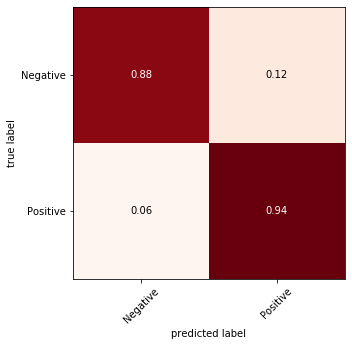

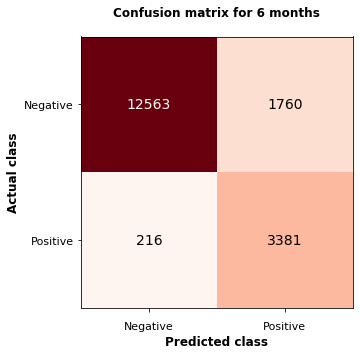

In [16]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(deep_preds_6['y'], deep_preds_6['CNN']['pred'])

fig6, ax = plot_confusion_matrix(conf_mat=cm, show_normed=True, show_absolute=False,
                     class_names=['Negative', 'Positive'], figsize=(5,5),
                               cmap='Reds')
fig7, ax = plot_confusion_matrix(conf_mat=cm, show_normed=False, show_absolute=True,
                     class_names=['Negative', 'Positive'], figsize=(5,5),
                               cmap='Reds')

ax.set_xlabel('Predicted class', fontdict=dict(weight='bold', size=12))
ax.set_ylabel('Actual class', fontdict=dict(weight='bold', size=12))
ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation=0)
ax.tick_params(axis = 'x', which = 'major', labelsize = 11, rotation=0, pad=10)

annotations = [child for child in ax.get_children() if isinstance(child, matplotlib.text.Text)][:4]
for txt in annotations:
    txt.set_fontsize(14)

plt.title('Confusion matrix for 6 months', fontdict={'size': 12, 'weight': 'bold'})

Text(0.5, 1.05, 'Confusion matrix for 12 months')

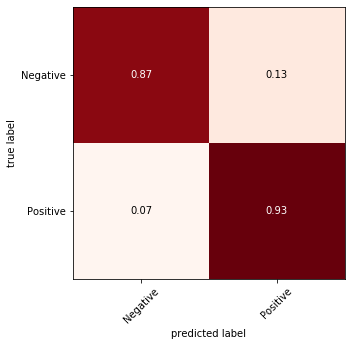

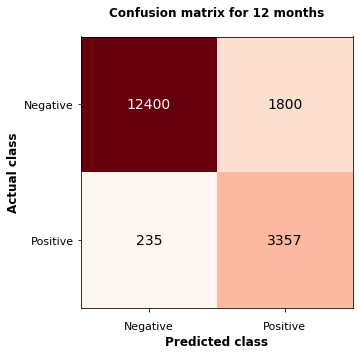

In [17]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(deep_preds_12['y'], deep_preds_12['CNN']['pred'])

fig12, ax = plot_confusion_matrix(conf_mat=cm, show_normed=True, show_absolute=False,
                     class_names=['Negative', 'Positive'], figsize=(5,5),
                               cmap='Reds')
fig13, ax = plot_confusion_matrix(conf_mat=cm, show_normed=False, show_absolute=True,
                     class_names=['Negative', 'Positive'], figsize=(5,5),
                               cmap='Reds')

ax.set_xlabel('Predicted class', fontdict=dict(weight='bold', size=12))
ax.set_ylabel('Actual class', fontdict=dict(weight='bold', size=12))
ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation=0)
ax.tick_params(axis = 'x', which = 'major', labelsize = 11, rotation=0, pad=10)

annotations = [child for child in ax.get_children() if isinstance(child, matplotlib.text.Text)][:4]
for txt in annotations:
    txt.set_fontsize(14)
    
plt.title('Confusion matrix for 12 months', fontdict={'size': 12, 'weight': 'bold'})

## Get ROC curve

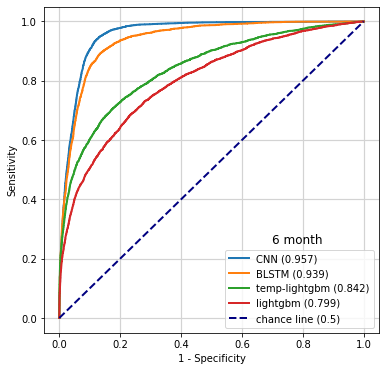

In [18]:
fig = plt.figure(figsize=(6,6))

lw = 2

for algo, model in deep_preds_6.items():
    if algo == 'y':
        continue
    fpr, tpr, thresh = roc_curve(deep_preds_6['y'], deep_preds_6[algo]['pred_proba'])
    auc = roc_auc_score(deep_preds_6['y'], deep_preds_6[algo]['pred_proba'])
    auc = round(auc, 3)
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)
    
# youden's index for CNN
# fpr, tpr, thresh = roc_curve(deep_preds_6['y'], deep_preds_6['CNN']['pred_proba'])
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresh[optimal_idx]
# print(optimal_threshold, optimal_idx)
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='x', color='black',
#             lw=lw, s=150, zorder=5,
#             label='CNN Youden index')
# plt.text(fpr[optimal_idx]-.02, tpr[optimal_idx]+.04, round(optimal_threshold, 2))

# Semi-temporal algos
rocs = []
for algo, model in st_preds_6.items():
    if algo == 'y':
        continue
    if algo != 'temp-lightgbm':
        continue
    fpr, tpr, thresh = roc_curve(st_preds_6['y'], st_preds_6[algo]['pred_proba'])
    auc = roc_auc_score(st_preds_6['y'], st_preds_6[algo]['pred_proba'])
    auc = round(auc, 3)
    rocs.append((algo, auc, [fpr, tpr]))
# sort legend by AUC
rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
for algo, auc, [fpr, tpr] in rocs:    
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

# ML algos
rocs = []
for algo, model in preds_6.items():
    if algo == 'y':
        continue
    if algo != 'lightgbm':
        continue
    fpr, tpr, thresh = roc_curve(preds_6['y'], preds_6[algo]['pred_proba'])
    auc = roc_auc_score(preds_6['y'], preds_6[algo]['pred_proba'])
    auc = round(auc, 3)
    rocs.append((algo, auc, [fpr, tpr]))
# sort legend by AUC
rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
for algo, auc, [fpr, tpr] in rocs:    
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)
    
# chance line
plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for 6 months', size=12)
plt.text(0.7,0.25, '6 month', fontsize=12)
plt.grid(linewidth=1.2, color='lightgray')
plt.legend(loc='lower right')

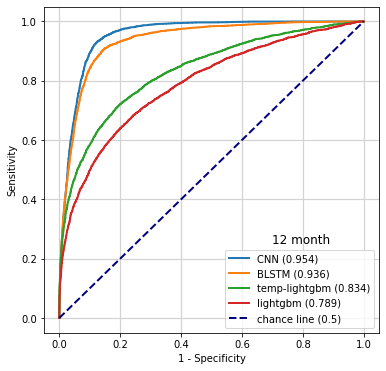

In [19]:
fig = plt.figure(figsize=(6,6))

lw = 2

for algo, model in deep_preds_12.items():
    if algo == 'y':
        continue
    fpr, tpr, thresh = roc_curve(deep_preds_12['y'], deep_preds_12[algo]['pred_proba'])
    auc = roc_auc_score(deep_preds_12['y'], deep_preds_12[algo]['pred_proba'])
    auc = round(auc, 3)
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)
    
# # youden's index for CNN
# fpr, tpr, thresh = roc_curve(deep_preds_12['y'], deep_preds_12['CNN']['pred_proba'])
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresh[optimal_idx]
# print(optimal_threshold, optimal_idx)
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='x', color='black',
#             lw=lw, s=150, zorder=5,
#             label='CNN Youden index')
# plt.text(fpr[optimal_idx]-.02, tpr[optimal_idx]+.04, round(optimal_threshold, 2))

# Semi-temporal algos
rocs = []
for algo, model in st_preds_12.items():
    if algo == 'y':
        continue
    if algo != 'temp-lightgbm':
        continue
    fpr, tpr, thresh = roc_curve(st_preds_12['y'], st_preds_12[algo]['pred_proba'])
    auc = roc_auc_score(st_preds_12['y'], st_preds_12[algo]['pred_proba'])
    auc = round(auc, 3)
    rocs.append((algo, auc, [fpr, tpr]))
# sort legend by AUC
rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
for algo, auc, [fpr, tpr] in rocs:    
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)
    
    
# ML algos
rocs = []
for algo, model in preds_12.items():
    if algo == 'y':
        continue
    if algo != 'lightgbm':
        continue
    fpr, tpr, thresh = roc_curve(preds_12['y'], preds_12[algo]['pred_proba'])
    auc = roc_auc_score(preds_12['y'], preds_12[algo]['pred_proba'])
    auc = round(auc, 3)
    rocs.append((algo, auc, [fpr, tpr]))
# sort legend by AUC
rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
for algo, auc, [fpr, tpr] in rocs:    
    plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)
    
# chance line
plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for 12 months', size=12)
plt.text(0.7,0.25, '12 month', fontsize=12)
plt.grid(linewidth=1.2, color='lightgray')
plt.legend(loc='lower right')

## Clean up

Delete all the predictions cached locally

In [20]:
! rm *.joblib

zsh:1: no matches found: *.joblib
